# Obteniendo la data

## Realizaremos web scraping a the World Economic Forum

In [11]:
import requests

In [12]:
url = 'http://reports.weforum.org/global-competitiveness-report-2018/competitiveness-rankings/#series=GCI4.A.02'
response = requests.get(url)
response.status_code

200

In [13]:
from bs4 import BeautifulSoup

In [14]:
import lxml.html as html

In [15]:
soup = BeautifulSoup(response.content, 'html')

In [18]:
soup.find_all('ol')

[]

### Usando Selenium

In [21]:
from selenium.webdriver import Chrome

In [22]:
driver = Chrome('./chromedriver')
driver.get(url)
driver.maximize_window()

In [24]:
tabla = driver.find_element_by_xpath('//ol[@class="series-economy-table__rows"]')

In [27]:
column1 = tabla.find_elements_by_xpath('.//span[@class="series-economy-table__economy-name"]')
#column1

In [28]:
column2 = tabla.find_elements_by_xpath('.//b[@class="series-economy-table__score"]')

In [31]:
#column1 = [column.text for column in column1]
#column1

In [33]:
#column2 = [column.text for column in column2]
#column2

In [34]:
driver.close()

In [35]:
import pandas as pd

In [36]:
doDataFrame = [column1, column2]

In [39]:
df = pd.DataFrame(doDataFrame).transpose()

In [45]:
#df.columns = ['country','score']
df

,country,score
0,Singapore,95.7
1,Hong Kong SAR,94.0
2,Switzerland,93.3
3,Netherlands,92.4
4,Japan,91.5
...,...,...
135,Liberia,34.8
136,Chad,34.1
137,Yemen,33.5
138,"Congo, Democratic Rep.",33.1


## Descargaremos datos del banco mundial

In [42]:
from pandas_datareader import wb

In [46]:
df2 = wb.download(indicator='NY.GDP.PCAP.PP.CD', country='all', start=2018, end=2018)

In [49]:
df2.reset_index(inplace=True)

In [50]:
df2.columns

Index(['country', 'year', 'NY.GDP.PCAP.PP.CD'], dtype='object')

In [51]:
df2.drop('year',axis=1, inplace=True)

In [53]:
df2.columns = ['country','GDP per capita, PPP']

In [54]:
df2.columns

Index(['country', 'GDP per capita, PPP'], dtype='object')

## Uniendo los datos para contruir nuestra propia base de datos!!!

In [57]:
dfFinal = pd.merge(df, df2, on='country')

In [58]:
dfFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              131 non-null    object 
 1   score                131 non-null    object 
 2   GDP per capita, PPP  131 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.1+ KB


In [59]:
dfFinal['score'] = pd.to_numeric(dfFinal['score'], downcast='float')

In [60]:
dfFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              131 non-null    object 
 1   score                131 non-null    float32
 2   GDP per capita, PPP  131 non-null    float64
dtypes: float32(1), float64(1), object(1)
memory usage: 3.6+ KB


## Una primera visualización de la correlacion entre las variables

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

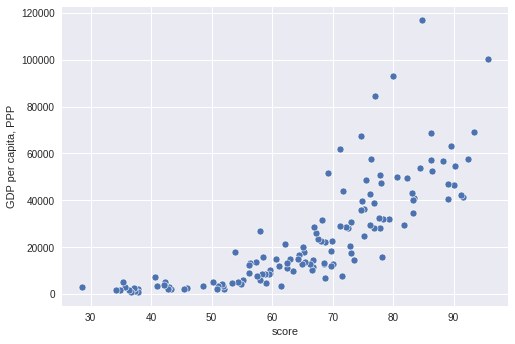

In [83]:
sns.scatterplot(x=dfFinal.score,
               y=dfFinal['GDP per capita, PPP'],
               data=dfFinal);

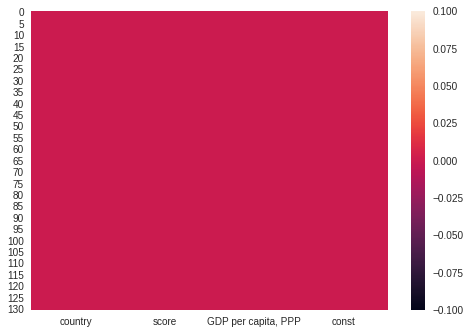

In [82]:
sns.heatmap(dfFinal.isnull());

## Regresión Lineal

In [68]:
import statsmodels.api as sm

In [69]:
dfFinal['const'] = 1

In [74]:
reg1 = sm.OLS(endog=dfFinal['GDP per capita, PPP'],
      exog=dfFinal[['const','score']])
type(reg1)

statsmodels.regression.linear_model.OLS

In [75]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [76]:
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     GDP per capita, PPP   R-squared:                       0.613
Model:                             OLS   Adj. R-squared:                  0.610
Method:                  Least Squares   F-statistic:                     204.0
Date:                 Thu, 04 Feb 2021   Prob (F-statistic):           2.41e-28
Time:                         22:47:47   Log-Likelihood:                -1437.7
No. Observations:                  131   AIC:                             2879.
Df Residuals:                      129   BIC:                             2885.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.996e+04   5369.159     -9.30

In [77]:
import numpy as np

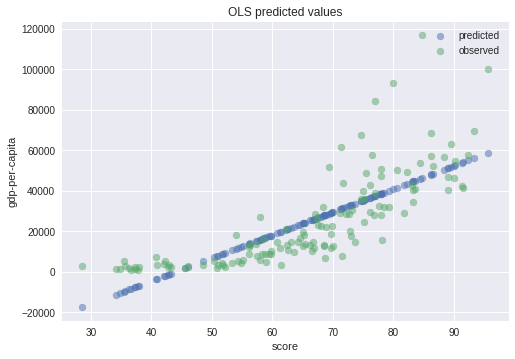

In [81]:
# Plot predicted values

fix, ax = plt.subplots()
ax.scatter(dfFinal.score, results.predict(), alpha=0.5,
        label='predicted')

# Plot observed values

ax.scatter(dfFinal.score, dfFinal['GDP per capita, PPP'], alpha=0.5,
        label='observed')

ax.legend()
ax.set_title('OLS predicted values')
ax.set_xlabel('score')
ax.set_ylabel('gdp-per-capita')
plt.show()

In [80]:
plt.style.use('seaborn')

In [84]:
print('Parameters: \n', results.params)
print('********************************')
print('Standard errors: \n', results.bse)
print('********************************')
print('Predicted values: \n', results.predict())

Parameters: 
 const   -49960.979571
score     1136.507047
dtype: float64
********************************
Standard errors: 
 const    5369.159278
score      79.564263
dtype: float64
********************************
Predicted values: 
 [ 58802.74136576  56075.13138947  55052.27331293  54029.4152364
  53802.11729532  52551.95260685  52438.30363632  51756.40114225
  51301.79658924  51188.14761871  50392.5961541   48346.88000102
  48119.58205995  48005.92441856  46301.16384795  45960.21693634
  44937.3588598   44710.06091873  44710.06091873  44482.7543068
  43573.55387166  43005.30034812  41641.48668911  40959.58419504
  40164.03273043  39141.17465389  38800.21907143  38686.57010089
  38572.92113036  38572.92113036  38231.96554789  37550.06305382
  37436.41408328  37322.76511275  36868.16055974  36640.85394781
  36527.20497728  35845.30248321  35504.34690074  35504.34690074
  35163.39998913  34936.0933772   34936.0933772   33685.93735959
  33117.68383605  33004.03486552  32890.38589498  32